[![Open In Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/aws/studio-lab-examples/blob/main/computer-vision/kmnist/cv-kminst.ipynb)

# Train an image classification model with PyTorch 

## Background

Image classification (or Image recognition) is a subdomain of computer vision in which an algorithm looks at an image and assigns it a tag from a collection of predefined tags or categories that it has been trained on.

Vision is responsible for 80-85 percent of our perception of the world, and we, as human beings, trivially perform classification daily on whatever data we come across.

Therefore, emulating a classification task with the help of neural networks is one of the first uses of computer vision that researchers thought about.


## Pytorch

[PyTorch](https://pytorch.org/) is an open-source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR). It is free and open-source software released under the Modified BSD license.

## MINST dataset

In this notebook we will use the KMINST dataset
https://pytorch.org/vision/stable/datasets.html#torchvision-datasets
    
## Steps in this notebook

The main steps are:
- install packages
- load dataset, what's train and test loader
- print out 1 image from KMINST dataset, with which library, 
- initiate the NN model, what's neural network, furthor reading: mlu-cv course
- train a model with config
- test a model 
- print a figure with train and test loss

- Install python packages for later use

    - **torch**: for install [PyTorch](https://pytorch.org/). PyTorch is a Python package that provides two high-level features: (1) Tensor computation (like NumPy) with strong GPU acceleration (2) Deep neural networks built on a tape-based autograd system

    - torchvision: 
    - torchsummary: 
    - matplotlib: 
    
Before running this notebook we need to install the required Python packages by opening a terminal window (click on File/New/Terminal) going to the location where the env_cv.yml file is located and launching the following two commands:
- conda env create -f env_cv.yml
- conda activate cv

After that we also need to switch the notebook kernel (click on Kernel/Change Kernel...) to **.conda-cv:Python**    

In [ ]:
# Uncomment these lines if you do not want to use the env_cv.yml file
#%pip install torch 
#%pip install torchvision
#%pip install torchsummary
#%pip install matplotlib
#%pip install ipywidgets

In [1]:
import torch
import torchvision

In [3]:
if torch.cuda.is_available():  
    device = "cuda:0" 
    !/usr/bin/nvidia-smi
else:  
    device = "cpu" 

Thu Feb  3 12:39:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   26C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import os
results_dir='results'
if not os.path.isdir(results_dir):
    !mkdir -p {results_dir}

In [5]:
## Create dataloader, in PyTorch, we feed the trainer data with use of dataloader
## We create dataloader with dataset from torchvision, 
## and we dont have to download it seperately, all automatically done

# Define batch size, batch size is how much data you feed for training in one iteration
batch_size_train = 64 # We use a small batch size here for training
batch_size_test = 1024 #

# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', 
                                           train=True, 
                                           download=True,
                                           transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', 
                                          train=False, 
                                          download=True,
                                          transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size_train, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size_test, 
                                          shuffle=True)

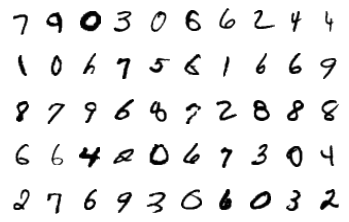

In [6]:
# import library

import matplotlib.pyplot as plt

# show the data

dataiter= iter(train_loader)
images, labels = dataiter.next()

figure = plt.figure()
num_images = 50
for index in range(1, num_images+1):
    plt.subplot(5,10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

Label: tensor(8)


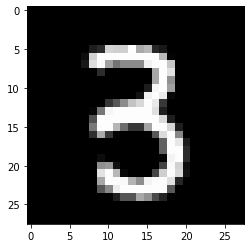

In [7]:
# We can check the dataloader
_, (example_datas, labels) = next(enumerate(test_loader))
sample = example_datas[0][0]
plt.imshow(sample, cmap='gray', interpolation='none')
print("Label: "+ str(labels[1]))

In [8]:
## Now we can start to build our CNN model
## We first import the pytorch nn module and optimizer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
## Then define the model class
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #input channel 1, output channel 10
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1)
        #input channel 10, output channel 20
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1)
        #dropout layer
        self.conv2_drop = nn.Dropout2d()
        #fully connected layer
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, 2)
        x = F.relu(x)
        x = x.view(-1, 320)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
## create model and optimizer
learning_rate = 0.01
momentum = 0.5
model = CNN().to(device) #using cpu here
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:

from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


/tmp/ipykernel_85/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [19]:
n_epochs = 5
log_interval = 100
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [20]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        if torch.cuda.is_available():  
            output = model(data.cuda())
            loss = F.nll_loss(output, target.cuda())
        else:
            output = model(data)
            loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    torch.save(model.state_dict(), './results/model.pth')
    torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [21]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available(): 
                output = model(data.cuda())
                test_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.cuda().data.view_as(pred)).sum()
            else:
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()                
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
import datetime

In [22]:
start = datetime.datetime.now()
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()
    
timediff = datetime.datetime.now() - start
print('Train time in seconds: ', timediff.total_seconds())

/tmp/ipykernel_85/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)



Test set: Avg. loss: 2.3245, Accuracy: 819/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.320459
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.039012
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.109940
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.970294
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.802043
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.677640
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.588911
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.623260
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.689363
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.460213

Test set: Avg. loss: 0.3689, Accuracy: 8900/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.593116
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.507734
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.390041
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.581439
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.317077
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.390522
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.568105
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.44877

Text(0, 0.5, 'negative log likelihood loss')

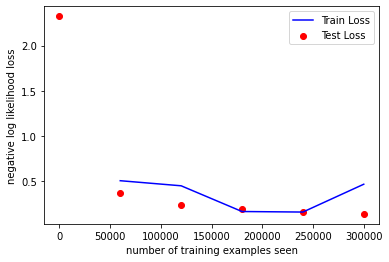

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
#fig

/tmp/ipykernel_85/4020281764.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


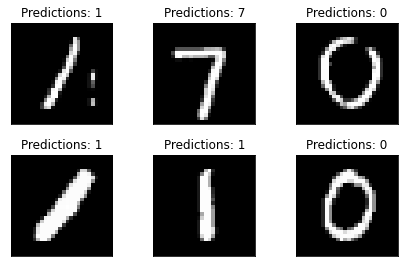

In [24]:
_, (example_datas, labels ) = next(enumerate(test_loader))
with torch.no_grad():
    if torch.cuda.is_available():
        output = model(example_datas.cuda())
    else:
        output = model(example_datas)
        
        
figure = plt.figure()
num_images = 5
for index in range(0, num_images+1):
    plt.subplot(2,3, index+1)
    plt.tight_layout()
    plt.imshow(example_datas[index][0], cmap='gray', interpolation='none')
    plt.title("Predictions: {}".format(output.data.max(1,keepdim=True)[1][index].item()) )
    plt.xticks([])
    plt.yticks([])
